In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch
from scipy.linalg import eigh

In [2]:
def QAOA_PQC(device: str, nq: int, n_layers: int, shots: int):
    # Define a device
    dev = qml.device(device, wires=nq, shots=shots)
    
    # Define the quantum function
    @qml.qnode(dev, interface='torch')
    def circuit(weights, hamiltonian: str):
        # Apply Hadamard gate on every qubit
        
        for q in range(nq):
            qml.Hadamard(wires=q)
            
        for i in range(n_layers):
         # Apply CNOT gate on the 1st layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
        # Apply Z-rotation gate to the 2nd layer
            for q in range(nq // 2):
                qml.RZ(weights[q], wires=2 * q + 1)
        
        # Apply CNOT gate on the 3rd layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q, (2 * q + 1)])
        
            # Apply CNOT gate on the 4th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
            # Apply Z-rotation gate on the 5th layer
            for q in range(nq // 2):
                qml.RZ(weights[nq//2+q], wires=2 * (q + 1))
        
            # Apply CNOT gate on the 6th layer
            for q in range(nq // 2):
                qml.CNOT(wires=[2 * q + 1, 2 * (q + 1)])
        
        # Apply X-rotation gate on every qubit
        for q in range(nq):
            qml.RX(weights[nq-1+q], wires=q)
            
        for i, char in enumerate(hamiltonian):
            if char == 'X':
                qml.Hadamard(wires=i)
            
            if char == 'Y':
                qml.RX(-np.pi/2, wires=i)
                
        return qml.probs()
    
    return circuit

In [3]:
def vqe_nrg(nq, qc, weights, j=1 ,h=1):
    
    interaction = torch.tensor(0.0)
    field = torch.tensor(0.0)
    
    zz_observable = 'Z' * nq
    x_observables = ['I' * i + 'X' + 'I' * (nq - i - 1) for i in range(nq)]
    
    probs = {zz_observable: qc(weights, zz_observable)}

    for obs in x_observables:
        probs[obs] = qc(weights, obs) 

    
    for i in range(2**nq):
        state = format(i, f'0{nq}b')

        # Interaction term calculation
        for k in range(nq-1):
            if state[k] == state[k+1]:
                interaction = interaction + 1 * probs[zz_observable][i]
            else:
                interaction = interaction - 1 * probs[zz_observable][i]
        
        # Field term calculation
        for k in range(nq):
            if state[k] == '0':
                field = field + 1 * probs[x_observables[k]][i]
            else:
                field = field - 1 * probs[x_observables[k]][i]

    E = (- j * interaction - h * field)
    E.requires_grad_(True)
    return E

def calculate_basis(n_sites):
    basis = []
    for i in range(2**n_sites):
        basis.append([int(x) for x in np.binary_repr(i, width=n_sites)])
    return basis


def vqe_magnetization(nq, qc, weights):
    zz_observable = 'z' * nq
    probs = qc(weights, zz_observable)
    
    n_sites = np.log2(len(probs))
    n_sites = int(n_sites)
    basis = calculate_basis(n_sites)
    M = 0.
    for i, bstate in enumerate(basis):
        bstate_M = 0.
        for spin in bstate:
            bstate_M += (probs[i] * (1 if spin else -1)) / len(bstate)
        M += abs(bstate_M)
    return M

In [11]:
def recalculate_energy_magnetization(device, shots, site_numbers, n_layers, h_values, j=1):
    recalculated_energies = {n_sites: {h: [] for h in h_values} for n_sites in site_numbers}
    recalculated_magnetizations = {n_sites: {h: [] for h in h_values} for n_sites in site_numbers}
    
    for n_sites in site_numbers:
        for idx, h in enumerate(h_values):
            qc = QAOA_PQC(device, n_sites, n_layers, shots)
            best_weights = torch.load(f"best_weights_n{n_sites}_h{h:.4f}.pt")
            
            energies = []
            magnetizations = []
            for _ in range(200):
                energy = vqe_nrg(n_sites, qc, best_weights, j, h).item()
                magnetization = vqe_magnetization(n_sites, qc, best_weights)
                
                energies.append(energy)
                magnetizations.append(magnetization)
        
            print(f'{n_sites} sites, {h} magnetic field case calculated')
                
            recalculated_energies[n_sites][h] = (np.mean(energies), np.std(energies))
            recalculated_magnetizations[n_sites][h] = (np.mean(magnetizations), np.std(magnetizations))
            
    return recalculated_energies, recalculated_magnetizations

In [12]:
device = 'default.qubit'
shots = 30000
n_layers = 2
j = 1.0

site_numbers=[3, 5, 7]
h_values = np.logspace(-2, 2, 20)

In [13]:
recalculated_energies, recalculated_magnetizations = recalculate_energy_magnetization(device, shots, site_numbers, n_layers, h_values, j)

3 sites, 0.01 magnetic field case calculated
3 sites, 0.016237767391887217 magnetic field case calculated
3 sites, 0.026366508987303583 magnetic field case calculated
3 sites, 0.04281332398719394 magnetic field case calculated
3 sites, 0.06951927961775606 magnetic field case calculated
3 sites, 0.11288378916846889 magnetic field case calculated
3 sites, 0.18329807108324356 magnetic field case calculated
3 sites, 0.29763514416313175 magnetic field case calculated
3 sites, 0.4832930238571752 magnetic field case calculated
3 sites, 0.7847599703514611 magnetic field case calculated
3 sites, 1.2742749857031335 magnetic field case calculated
3 sites, 2.06913808111479 magnetic field case calculated
3 sites, 3.359818286283781 magnetic field case calculated
3 sites, 5.455594781168514 magnetic field case calculated
3 sites, 8.858667904100823 magnetic field case calculated
3 sites, 14.38449888287663 magnetic field case calculated
3 sites, 23.357214690901213 magnetic field case calculated
3 sites,

In [26]:
def pauli_matrices():
    pz = np.array([[1, 0],
                   [0, -1]])

    px = np.array([[0, 1],
                   [1, 0]])

    id = np.array([[1, 0],
                   [0, 1]])
    return px, pz, id

def apply_pauli(matrix, pos, n):
    id = np.eye(2)

    result = 1
    for i in range(n):
        if i == pos:
            result = np.kron(result, matrix)
        else:
            result = np.kron(result, id)
    return result

def hamiltonian(n_sites, h, j, periodic=False):
    px, pz, id = pauli_matrices()
    
    H_coupling = np.zeros((2**n_sites, 2**n_sites))
    H_quantum = np.zeros((2**n_sites, 2**n_sites))
    
    for i in range(n_sites - 1):
        H_coupling -= j * np.dot(apply_pauli(pz, i, n_sites), apply_pauli(pz, i + 1, n_sites))
    
    if periodic:
        H_coupling -= j * np.dot(apply_pauli(pz, n_sites - 1, n_sites), apply_pauli(pz, 0, n_sites))
    
    for i in range(n_sites):
        H_quantum -= h * apply_pauli(px, i, n_sites)
    
    H = H_coupling + H_quantum
    return H

def calculate_basis(n_sites):
    basis = []
    for i in range(2**n_sites):
        basis.append([int(x) for x in np.binary_repr(i, width=n_sites)])
    return basis

def calculate_magnetization(state):
    n_sites = np.log2(len(state))
    n_sites = int(n_sites)
    basis = calculate_basis(n_sites)
    M = 0.
    for i, bstate in enumerate(basis):
        bstate_M = 0.
        for spin in bstate:
            bstate_M += (state[i]**2 * (1 if spin else -1)) / len(bstate)
        M += abs(bstate_M)
    return M

def ground_state_properties(n_sites, h, j, periodic=False):
    # Construct the Hamiltonian
    H = hamiltonian(n_sites, h, j, periodic)
    
    # Perform exact diagonalization
    eigenvalues, eigenvectors = eigh(H)
    
    # Ground state energy (smallest eigenvalue)
    ground_state_energy = eigenvalues[0]
    
    # Ground state vector (eigenvector corresponding to the smallest eigenvalue)
    ground_state = eigenvectors[:, 0]
    
    # Calculate basis states
    
    # Calculate magnetization
    ground_state_magnetization = calculate_magnetization(ground_state)
    
    return ground_state_energy, ground_state_magnetization

In [27]:
periodic = False

magnetizations = {n_sites: [] for n_sites in site_numbers}
energies = {n_sites: [] for n_sites in site_numbers}
for n_sites in site_numbers:
    for h in h_values:
        energy, magnetization = ground_state_properties(n_sites, h, j, periodic)
        energies[n_sites].append(energy)
        magnetizations[n_sites].append(magnetization)
        print(f"n_site: {n_sites}, h_value: {h}, energy: {energy}, magnetization: {magnetization}")

n_site: 3, h_value: 0.01, energy: -2.0001260009924318, magnetization: 0.9999619162456799
n_site: 3, h_value: 0.016237767391887217, energy: -2.0003338691454187, magnetization: 0.999898625780186
n_site: 3, h_value: 0.026366508987303583, energy: -2.0008873604773703, magnetization: 0.9997286003258777
n_site: 3, h_value: 0.04281332398719394, energy: -2.002369917429248, magnetization: 0.9992668609271853
n_site: 3, h_value: 0.06951927961775606, energy: -2.006377928101033, magnetization: 0.9979926109071946
n_site: 3, h_value: 0.11288378916846889, energy: -2.01736365920998, magnetization: 0.9944000183021178
n_site: 3, h_value: 0.18329807108324356, energy: -2.0480263292847907, magnetization: 0.9840672677867033
n_site: 3, h_value: 0.29763514416313175, energy: -2.134886852497447, magnetization: 0.9547872925385752
n_site: 3, h_value: 0.4832930238571752, energy: -2.375923329179447, magnetization: 0.8834447567022226
n_site: 3, h_value: 0.7847599703514611, energy: -2.974093546074011, magnetization: 0.

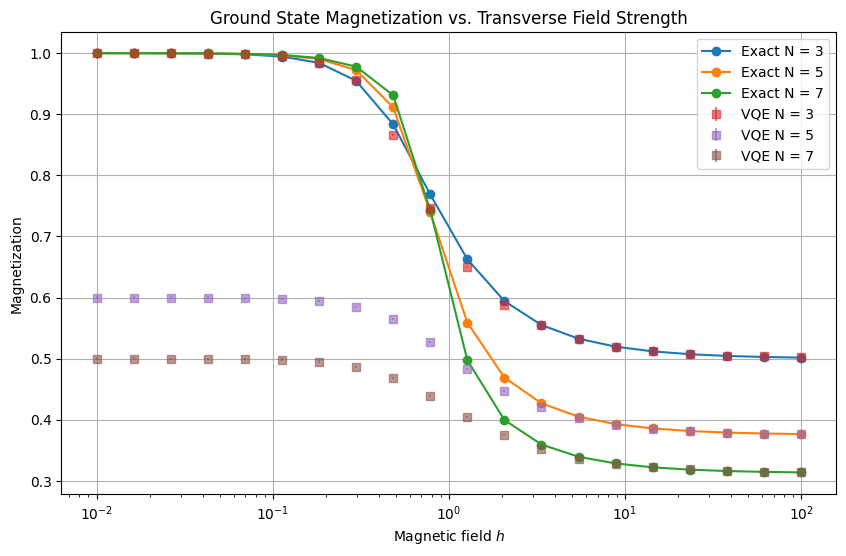

In [28]:
plt.figure(figsize=(10, 6))
for n_sites in site_numbers:
    plt.plot(h_values, magnetizations[n_sites], 'o-', label=f'Exact N = {n_sites}')

# Overlaying the VQE magnetization data as scatter plot with error bars
for n_sites in site_numbers:
    vqe_magnetization_means = [recalculated_magnetizations[n_sites][h][0] for h in h_values]
    vqe_magnetization_stds = [recalculated_magnetizations[n_sites][h][1] for h in h_values]
    plt.errorbar(h_values, vqe_magnetization_means, yerr=vqe_magnetization_stds, fmt='s', label=f'VQE N = {n_sites}', alpha=0.6)

plt.xscale('log')
plt.xlabel(r'Magnetic field $h$')
plt.ylabel(r'Magnetization')
# plt.title('Ground State Magnetization vs. Transverse Field Strength')
plt.legend()
plt.grid(True)
plt.savefig('comparison_ground_state_magnetization.png')  # Save the magnetization plot
plt.show()

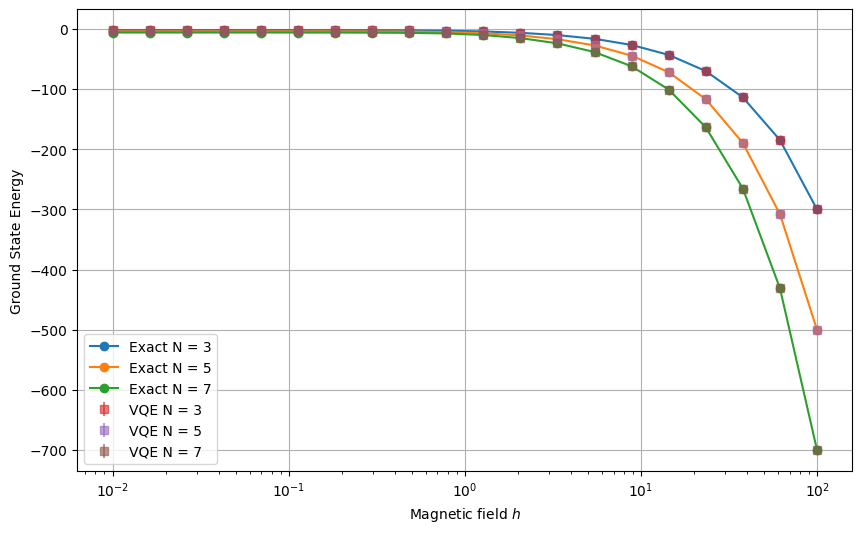

In [30]:
plt.figure(figsize=(10, 6))
for n_sites in site_numbers:
    plt.plot(h_values, energies[n_sites], 'o-', label=f'Exact N = {n_sites}')

# Overlaying the VQE magnetization data as scatter plot with error bars
for n_sites in site_numbers:
    vqe_energies_means = [recalculated_energies[n_sites][h][0] for h in h_values]
    vqe_energies_stds = [recalculated_energies[n_sites][h][1] for h in h_values]
    plt.errorbar(h_values, vqe_energies_means, yerr=vqe_energies_stds, fmt='s', label=f'VQE N = {n_sites}', alpha=0.6)

plt.xscale('log')
plt.xlabel(r'Magnetic field $h$')
plt.ylabel(r'Ground State Energy')
# plt.title('Ground State Energy vs. Transverse Field Strength')
plt.legend()
plt.grid(True)
plt.savefig('comparison_ground_state_energy.png')  # Save the magnetization plot
plt.show()